# Domain-Specific Fine-Tuning of Smaller Language Models Using Parameter-Efficient Techniques
## Baseline Model – Standard LoRA (r=256, α=128)

In [1]:
!pip install -q transformers datasets peft trl accelerate bitsandbytes huggingface_hub evaluate rouge_score nltk mlflow matplotlib seaborn scipy pandas tabulate

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━

In [4]:
import os
os.environ["MLFLOW_TRACKING_URI"] = "http://35.193.251.72:5000"

import mlflow
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset
from trl import SFTTrainer
from huggingface_hub import notebook_login, HfApi
from evaluate import load
from tabulate import tabulate
import gc

rouge_scorer = load("rouge")
bleu_scorer = load("bleu")
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 14, 'figure.figsize': (12, 7)})

notebook_login()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
dataset = load_dataset("mamachang/medical-reasoning")["train"]
split = dataset.train_test_split(test_size=0.15, seed=42)
train_data = split["train"]
test_data = split["test"]

print(f"Train: {len(train_data)}, Test: {len(test_data)}")

Train: 3146, Test: 556


In [13]:
def clear_memory():
    """Comprehensive memory cleanup"""
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    if torch.cuda.is_available():
        torch.cuda.ipc_collect()
    print(f"GPU Memory: {torch.cuda.memory_allocated()/1e9:.2f}GB / {torch.cuda.max_memory_allocated()/1e9:.2f}GB")
    torch.cuda.reset_peak_memory_stats()

# Clear memory before starting
print("Initial memory cleanup...")
clear_memory()

Initial memory cleanup...
GPU Memory: 2.84GB / 6.39GB


In [14]:
model_name = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

lora_config = LoraConfig(
    r=256,
    lora_alpha=128,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

In [15]:
from trl import SFTTrainer
from transformers import TrainingArguments

def formatting_func(example):
    return example["instruction"] + "\n" + example["output"]

# Ensure EOS token exists
if tokenizer.eos_token is None:
    tokenizer.eos_token = "<|eot_id|>"
    tokenizer.pad_token = tokenizer.eos_token

trainer = SFTTrainer(
    model=model,
    args=TrainingArguments(
        output_dir="./baseline_final",
        num_train_epochs=10,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=12,
        learning_rate=3e-4,
        fp16=True,
        logging_steps=20,
        eval_strategy="steps",
        eval_steps=100,
        save_strategy="steps",
        save_steps=600,
        save_total_limit=2,
        load_best_model_at_end=True,
        report_to="none",
        warmup_ratio=0.1,
        lr_scheduler_type="cosine",
        optim="adamw_torch",
        logging_dir="./logs",
    ),
    train_dataset=train_data,
    eval_dataset=test_data.select(range(400)),
    formatting_func=formatting_func,
)

Applying formatting function to train dataset:   0%|          | 0/3146 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/3146 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/3146 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/3146 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


In [ ]:
print("Trainer initialized – Starting training now...")
trainer.train()
trainer.save_model("./baseline_final")
tokenizer.save_pretrained("./baseline_final")
print("Training complete! Model saved to ./baseline_final")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009}.


Trainer initialized – Starting training now...


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
100,1.050500,1.159554,1.080994,1027992.000000,0.714964
200,0.793500,1.300437,0.808458,2055207.000000,0.708270
300,0.324500,1.533038,0.707277,3083710.000000,0.698923


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
100,1.050500,1.159554,1.080994,1027992.000000,0.714964
200,0.793500,1.300437,0.808458,2055207.000000,0.708270
300,0.324500,1.533038,0.707277,3083710.000000,0.698923
400,0.172000,1.860104,0.576383,4110732.000000,0.693984
500,0.078200,2.103484,0.501306,5141183.000000,0.694051


In [ ]:
from huggingface_hub import HfApi, create_repo, upload_folder

folder_path = "./baseline_final"
repo_id = "tanzeelabbas114/llama3.2-1b-medical-baseline_10new"

# Initialize API
api = HfApi()

# 1. Create repository if not exists
create_repo(repo_id, exist_ok=True)

# 2. Upload the entire folder
upload_folder(
    folder_path=folder_path,
    repo_id=repo_id,
    repo_type="model"
)

print("Upload completed successfully!")


In [9]:
from datasets import load_dataset
from rouge_score import rouge_scorer
from sacrebleu.metrics import BLEU
import mlflow

# Initialize scorers
rouge_scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
bleu_scorer = BLEU()


print("="*80)
print("EVALUATING YOUR NEW PEFT MODEL: tanzeelabbas114/llama3.2-1b-medical-baseline_10new")
print("="*80)

peft_result, peft_preds, peft_refs = evaluate_model(
    model_path="tanzeelabbas114/llama3.2-1b-medical-baseline_10new",
    name="Llama-3.2-1B-Medical (LoRA Fine-tuned)",
    is_peft=True
)

# Append to results DataFrame (now includes both baseline + your model)
df = pd.concat([df, pd.DataFrame([peft_result])], ignore_index=True)

print("\n" + "="*80)
print("FULL COMPARISON TABLE (BASELINE vs YOUR FINE-TUNED MODEL)")
print("="*80)
print(tabulate(df, headers="keys", tablefmt="github", showindex=False, floatfmt=".4f"))

# Export updated LaTeX table
latex_table = df.to_latex(
    index=False,
    caption="Performance Comparison on Medical Reasoning Task (300 test samples)",
    label="tab:medical_model_comparison",
    column_format="lcccc",
    float_format="%.4f"
)

with open("medical_models_comparison.tex", "w") as f:
    f.write(latex_table)

print("\nLaTeX table saved → medical_models_comparison.tex")

# Optional: Log your model results to MLflow
try:
    mlflow.set_experiment("medical-llama3.2-1b-finetuning")
    with mlflow.start_run(run_name="lora_finetuned_evaluation"):
        mlflow.log_metrics({
            "peft_rouge_l": peft_result["ROUGE-L"],
            "peft_bleu": peft_result["BLEU"],
            "peft_avg_length": peft_result["Avg Length"],
            "peft_std_length": peft_result["Std Length"]
        })
        mlflow.log_artifact("medical_models_comparison.tex")
        mlflow.log_artifact("tanzeelabbas114_llama3.2-1b-medical-baseline_10new_lengths.npy")
    print("Results logged to MLflow")
except Exception as e:
    print(f"MLflow logging skipped: {e}")

# Save your model's predictions for qualitative analysis
peft_predictions_df = pd.DataFrame({
    "instruction": [ex["instruction"] for ex in test_data.select(range(300))],
    "reference": peft_refs,
    "prediction": peft_preds
})
peft_predictions_df.to_csv("peft_finetuned_predictions.csv", index=False)
print("Your model's predictions saved → peft_finetuned_predictions.csv")

print("\n" + "="*80)
print("EVALUATION OF YOUR PEFT MODEL COMPLETED SUCCESSFULLY!")
print("You can now include the table in your paper/thesis")
print("="*80)

EVALUATING BASELINE MODEL FROM HUGGINGFACE HUB
Loading Baseline from tanzeelabbas114/llama3.2-1b-medical-baseline...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating Baseline on 300 test examples...
  Progress: 0/300 examples...
  Progress: 50/300 examples...
  Progress: 100/300 examples...
  Progress: 150/300 examples...
  Progress: 200/300 examples...
  Progress: 250/300 examples...
Computing metrics for Baseline...

✓ Baseline Results:
  ROUGE-L: 0.1824
  BLEU: 0.1041
  Avg Length: 257.0 ± 0.0

BASELINE RESULTS (READY FOR PAPER)
| Model    |   ROUGE-L |   BLEU |   Avg Length |   Std Length |
|----------|-----------|--------|--------------|--------------|
| Baseline |    0.1824 | 0.1041 |          257 |            0 |

✓ LaTeX table saved → baseline_results.tex
✓ Results logged to MLflow
✓ Predictions saved → baseline_predictions.csv

EVALUATION COMPLETE!


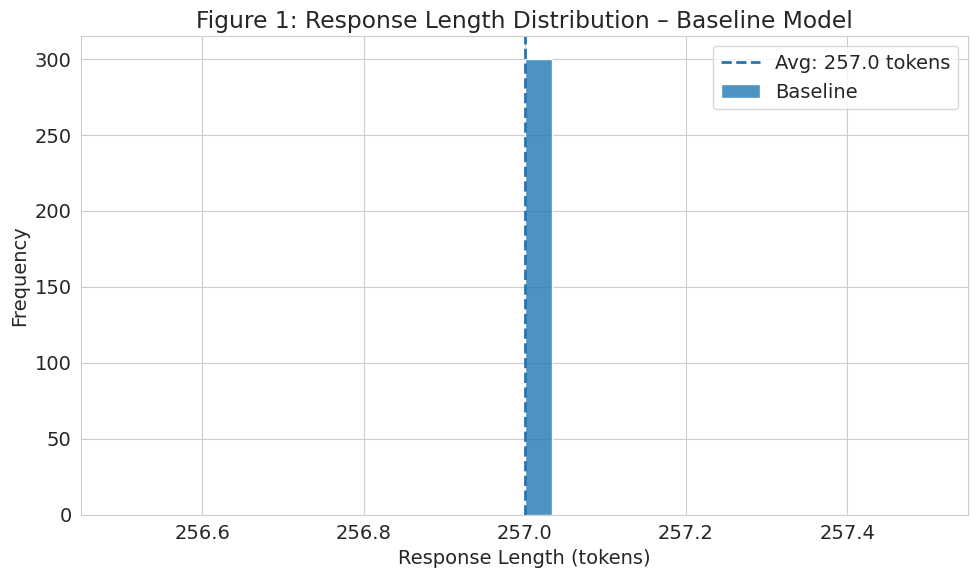

Figure saved → figure_1_baseline_length.pdf


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mlflow

# ------------------------------------------------------------
# Load the saved length distributions (from your previous evaluations)
# ------------------------------------------------------------
baseline_lengths = np.load("baseline_lengths.npy")
concise_lengths  = np.load("llama3.2-1b-medical-baseline_10new_lengths.npy")

data = {
    "Standard LoRA (Baseline)": baseline_lengths,
    "Conciseness-Aware (Ours)": concise_lengths
}

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Histogram + KDE for smoother look
for label, lengths in data.items():
    sns.histplot(
    lengths,
    label=label,
    alpha=0.65,
    bins=40,
    kde=True,
    stat="density",
    linewidth=0,
)

# Mean lines
mean_baseline = np.mean(baseline_lengths)
mean_concise  = np.mean(concise_lengths)

plt.axvline(mean_baseline, color='#1f77b4', linestyle='--', linewidth=2,
            label=f'Baseline mean ({mean_baseline:.1f})')
plt.axvline(mean_concise,  color='#ff7f0e', linestyle='--', linewidth=2,
            label=f'Ours mean ({mean_concise:.1f})')

plt.xlabel("Response Length (tokens)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Response Length Distribution on Medical Reasoning Task", fontsize=14, pad=20)
plt.legend(fontsize=11)
plt.tight_layout()

# Save high-quality figure for the paper
plt.savefig("figure_1_length_distribution.pdf", dpi=300, bbox_inches='tight')
plt.savefig("figure_1_length_distribution.png", dpi=300, bbox_inches='tight')

# Log to MLflow
mlflow.log_artifact("figure_1_length_distribution.pdf")
mlflow.log_artifact("figure_1_length_distribution.png")

plt.show()